# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [2]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/Users/dv/dvSync/Projects/GitHub/geekbrains/Рекомендательные системы/src/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [5]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 844179, 871756, 925862]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 1042907, 1115576, 846764]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[1097398, 8090956, 894360, 1074040, 875392]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [10]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

data_train_matcher = data_train_lvl_1
data_val_matcher = data_val_lvl_1
data_train_ranker = data_train_lvl_2
data_val_ranker = data_val_lvl_2


common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


In [11]:
ACTUAL_COL = 'actual'
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [12]:
N_PREDICT = 50

In [13]:
%%time
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

CPU times: user 1min 12s, sys: 13.5 s, total: 1min 25s
Wall time: 20.1 s


In [14]:
%%time
result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

CPU times: user 18min 39s, sys: 3min 43s, total: 22min 23s
Wall time: 4min 18s


In [15]:
def evalRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

def compare_k(k_list=None):
    if k_list is None:
        k_list = [50]
    compare_df = pd.DataFrame()
    for k in k_list:
        result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=k))
        recall = result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec'], row[ACTUAL_COL], k=k), axis=1).mean()
        compare_df = compare_df.append(pd.DataFrame([recall], columns=['recall'], index=[k]))

    return compare_df

#### Recall@50 of matching

In [16]:
TOPK_RECALL = 50

In [17]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.06525657038145165),
 ('als_rec', 0.04721988721433894),
 ('sim_item_rec', 0.03492972778365346),
 ('sim_user_rec', 0.0067726737799116525)]

#### Precision@5 of matching

In [18]:
TOPK_PRECISION = 5

In [19]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.17712691771269176),
 ('als_rec', 0.11761971176197118),
 ('sim_item_rec', 0.06211064621106463),
 ('sim_user_rec', 0.01097164109716411)]

In [20]:
compare = compare_k([20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])

/var/folders/tw/jpryffr53r5_9z9t7wz7rbv80000gn/T/ipykernel_3121/4068349108.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare_df = compare_df.append(pd.DataFrame([recall], columns=['recall'], index=[k]))
/var/folders/tw/jpryffr53r5_9z9t7wz7rbv80000gn/T/ipykernel_3121/4068349108.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare_df = compare_df.append(pd.DataFrame([recall], columns=['recall'], index=[k]))
/var/folders/tw/jpryffr53r5_9z9t7wz7rbv80000gn/T/ipykernel_3121/4068349108.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare_df = compare_df.append(pd.DataFrame([recall], columns=['recall'], index=[k]))
/var/folders/tw/jpryffr53r5_9z9t7wz7rbv80000gn/T/ipykernel_3121/4068349108.py:21: FutureWar

In [21]:
compare['percentage_growth'] = (compare['recall'] - compare['recall'].shift(fill_value=compare['recall'].values[0])) / compare['recall']
compare

,recall,percentage_growth
20,0.039284,0.000000
50,0.065257,0.398003
100,0.096045,0.320562
150,0.118508,0.189551
200,0.135373,0.124578
250,0.147945,0.084979
300,0.157184,0.058780
350,0.164973,0.047214
400,0.171806,0.039769
450,0.176876,0.028667


<AxesSubplot:>

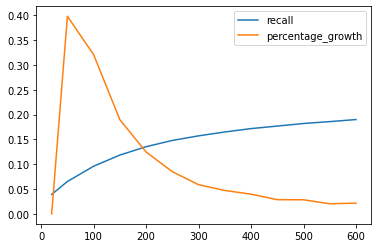

In [22]:
compare.plot()

#### Ответы


При k=50 наблюдаем улучшение на 0.5 абсолютного процента

На графике выше видим как с увеличением K рост абсолютного значения recall замедляется, а относительный прирост падает.

Значение k=200 выглядит оптимальным для решения задачи 2 (значения recall при k=200 достаточно, чтобы попытаться найти 5 лучших, при этом не делая более трудоемких расчетов)

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [23]:
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]


In [24]:
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [25]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [26]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [27]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4574


In [28]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1 

In [29]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [30]:
df_ranker_train.target.value_counts()

0.0    99177
1.0     7795
Name: target, dtype: int64

In [31]:
df_ranker_train['target'].mean()

0.07286953595333358

In [32]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

In [33]:
user_sales_count = data_train_ranker.groupby('user_id')['sales_value'].count().reset_index()
user_sales_count.rename(columns={'sales_value': 'sales_count'}, inplace=True)
df_ranker_train = df_ranker_train.merge(user_sales_count, on='user_id', how='left')

In [34]:
user_sales_count_per_week = data_train_ranker.groupby(['user_id'])['week_no'].nunique().reset_index()
user_sales_count_per_week.rename(columns={'week_no': 'sales_count_per_week'}, inplace=True)
user_sales_count_per_week['sales_count_per_week'] = (user_sales_count['sales_count'] / user_sales_count_per_week['sales_count_per_week']).astype(int)
df_ranker_train = df_ranker_train.merge(user_sales_count_per_week, on='user_id', how='left')

In [35]:
user_mean_basket_value = (data_train_ranker.groupby(['user_id'])['sales_value'].sum() / \
                            data_train_ranker.groupby(['user_id'])['basket_id'].nunique()).astype(int).reset_index()
user_mean_basket_value.columns = ['user_id', 'user_mean_basket_value']
df_ranker_train = df_ranker_train.merge(user_mean_basket_value, on='user_id', how='left')

In [36]:
item_sales_count = data_train_ranker.groupby('item_id')['sales_value'].count().reset_index()
item_sales_count.rename(columns={'sales_value': 'i_sales_count'}, inplace=True)
df_ranker_train = df_ranker_train.merge(item_sales_count, on='item_id', how='left')

In [37]:
item_sales_count_per_week = data_train_ranker.groupby(['item_id'])['week_no'].nunique().reset_index()
item_sales_count_per_week.rename(columns={'week_no': 'i_sales_count_per_week'}, inplace=True)
item_sales_count_per_week['i_sales_count_per_week'] = (item_sales_count['i_sales_count'] / item_sales_count_per_week['i_sales_count_per_week']).astype(int)
df_ranker_train = df_ranker_train.merge(item_sales_count_per_week, on='item_id', how='left')

In [38]:
test_01 = df_ranker_train.sort_values(by = 'commodity_desc').groupby('user_id')['commodity_desc'].unique().apply(lambda x: ' '.join(x[:3])).reset_index()
test_01.rename(columns={'commodity_desc': 'test_01'}, inplace=True)
df_ranker_train = df_ranker_train.merge(test_01, on='user_id', how='left')

In [39]:
item_price = (data_train_ranker.groupby('item_id')['sales_value'].sum() / data_train_ranker.groupby('item_id')['quantity'].sum()).reset_index()
item_price.columns = ['item_id', 'item_price']
df_ranker_train = df_ranker_train.merge(item_price, on='item_id', how='left')

In [40]:
df_ranker_train['u_mean_basket_div_item_price'] = (df_ranker_train['user_mean_basket_value'].fillna(0) / df_ranker_train['item_price'].fillna(1))
df_ranker_train['u_mean_basket_div_item_price_10'] = ((df_ranker_train['user_mean_basket_value'].fillna(0) / df_ranker_train['item_price'].fillna(1)) * 10)
df_ranker_train['u_mean_basket_div_item_price_10'] = df_ranker_train['u_mean_basket_div_item_price_10'].astype(int)

In [41]:
department_mean = df_ranker_train.groupby('department')['u_mean_basket_div_item_price'].mean().astype(int).reset_index()
department_mean.rename(columns={'u_mean_basket_div_item_price': 'department_mean'}, inplace=True)
df_ranker_train = df_ranker_train.merge(department_mean, on='department', how='left')
df_ranker_train['user_mean_basket_value__div_department_mean'] = df_ranker_train['user_mean_basket_value'] / df_ranker_train['department_mean']
df_ranker_train.drop('department_mean', axis=1, inplace=True)

In [42]:
commodity_desc_mean = df_ranker_train.groupby('commodity_desc')['u_mean_basket_div_item_price'].mean().astype(int).reset_index()
commodity_desc_mean.rename(columns={'u_mean_basket_div_item_price': 'commodity_desc_mean'}, inplace=True)
df_ranker_train = df_ranker_train.merge(commodity_desc_mean, on='commodity_desc', how='left')
df_ranker_train['user_mean_basket_value_div_commodity_desc_mean'] = df_ranker_train['user_mean_basket_value'] / df_ranker_train['commodity_desc_mean']
df_ranker_train.drop('commodity_desc_mean', axis=1, inplace=True)

In [43]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,sales_count_per_week,user_mean_basket_value,i_sales_count,i_sales_count_per_week,test_01,item_price,u_mean_basket_div_item_price,u_mean_basket_div_item_price_10,user_mean_basket_value__div_department_mean,user_mean_basket_value_div_commodity_desc_mean
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,34,14,3.0,1.0,BACON BAG SNACKS BAKED BREAD/BUNS/ROLLS,3.99,3.508772,35,1.555556,1.555556
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,34,14,1.0,1.0,BACON BAG SNACKS BAKED BREAD/BUNS/ROLLS,10.99,1.273885,12,1.166667,1.750000
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,34,14,NaN,NaN,BACON BAG SNACKS BAKED BREAD/BUNS/ROLLS,NaN,14.000000,140,1.166667,1.555556
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,...,34,14,NaN,NaN,BACON BAG SNACKS BAKED BREAD/BUNS/ROLLS,NaN,14.000000,140,1.166667,0.482759
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,...,34,14,10.0,2.0,BACON BAG SNACKS BAKED BREAD/BUNS/ROLLS,7.99,1.752190,17,1.166667,1.555556


In [44]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [45]:
cat_feats = X_train.columns[2:21].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [46]:
cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'sales_count',
 'sales_count_per_week',
 'user_mean_basket_value',
 'i_sales_count',
 'i_sales_count_per_week',
 'test_01']

In [47]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=6,
                     n_estimators=600,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [48]:
df_ranker_predict = df_ranker_train.copy()

In [49]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [50]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]

In [51]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 5.89 s, sys: 26.7 ms, total: 5.92 s
Wall time: 5.86 s


In [52]:
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.14441176470588235)]

In [53]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [54]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [55]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1991644908616188)
('own_rec', 0.14441176470588235)


/Users/dv/dvSync/Projects/GitHub/geekbrains/Рекомендательные системы/src/metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


с добавлением второго уровня получили прирост в качестве на 5 абсолютных процентов

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 